In [1]:
# change working directory to the root of the project
import os
os.chdir('..')

# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import pyprotoevo

sim_name = 'gaia-articuno-sint'

In [3]:
sim_files = pyprotoevo.utils.SimulationFiles(sim_name)

In [9]:
import json


def read_json(path):
    with open(path) as f:
        return json.load(f)


stats_dir = sim_files.save_dir  / 'stats/summaries'
genomes_dir = sim_files.save_dir / 'stats/protozoa-genomes'

stats = {
    f.stem: read_json(f) for f in stats_dir.glob('*.json')
}

genomes = {
    f.stem: read_json(f) for i, f in enumerate(genomes_dir.glob('*.json'))
    if i % 10 == 0
}

In [12]:
genomes.keys()

dict_keys(['2023-02-27-23-02-24', '2023-02-27-23-50-25', '2023-02-28-00-37-01', '2023-02-28-01-27-37', '2023-02-28-02-12-12', '2023-02-28-02-59-40', '2023-02-28-03-49-50', '2023-02-28-04-44-51', '2023-02-28-05-43-33', '2023-02-28-06-38-13', '2023-02-28-07-35-54', '2023-02-28-08-33-30', '2023-02-28-09-31-31', '2023-02-28-10-35-50'])

In [17]:
list(genomes.values())[0][0].keys()

dict_keys(['sensorNeuronGenes', 'outputNeuronGenes', 'hiddenNeuronGenes', 'nNeuronGenes', 'synapseGenes', 'numStructuralMutations', 'nSensors', 'nOutputs'])

In [165]:
black_list = ['Node', 'Organelle', 'Log', 'Molecule']
', '.join([
    key for key in stats['2023-02-27-23-50-25']['stats'].keys()
    if all(x not in key for x in black_list)
])

'Num Spikes Count, Died from overcrowding, Growth Rate Mean, Num Spikes Mean, Speed Mean, Available Energy Mean, Crossover Events, Died from suffocation, Sleeping, Max Protozoa Generation, GRN Size Mean, Size Mean, Num Mutations Mean, Plants, Died from exceeding environment capacity, Time Elapsed, GRN Depth Mean, Meat Digestion Rate Mean, Age Mean, Meat Created, Physics Step Time, Joints, Protozoa, Split Radius Mean, Meat to Digest Mean, Death Rate Mean, Max Plant Generation, Herbivore Factor Mean, Has Mated Mean, Mean Mutation Chance Mean, Died from murder, Died from old age, Died from cytokinesis, Contacts, Being Engulfed Mean, Construction Mass Mean, Health Mean, Died from the void, Protozoa Created, Fixtures, Repair Rate Mean, Generation Mean, Bodies, Died from being eaten, Total Mass Mean, Plant Digestion Rate Mean, Proxies, Construction Mass Limit Mean, Plant to Digest Mean, Plants Created, Meat Pellets'

In [169]:
def get_stat_value(stats, stat_name):
    return stats['stats'][stat_name]['value']


def create_counts_df(time, genomes):
    df = pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ]).value_counts().reset_index().rename(columns={0: 'count'})
    df['time'] = time
    df['generation'] = get_stat_value(stats[time], 'Generation Mean')
    df['num_protozoa'] = get_stat_value(stats[time], 'Protozoa')
    df['fixation'] = df['count'] / df['num_protozoa']
    return df

gene_signatures_df = pd.concat([
    create_counts_df(time, genomes)
    for time, genomes in genomes.items()
])

In [172]:
gene_signatures_df

,signature,count,time,generation,num_protozoa,fixation
0,-9223338258144606926,1,2023-02-27-23-02-24,1.0000,500,0.0020
1,3112727189525186521,1,2023-02-27-23-02-24,1.0000,500,0.0020
2,3116372082110318883,1,2023-02-27-23-02-24,1.0000,500,0.0020
3,3116208594081170199,1,2023-02-27-23-02-24,1.0000,500,0.0020
4,3116086267397292415,1,2023-02-27-23-02-24,1.0000,500,0.0020
...,...,...,...,...,...,...
1918,-107751674414350122,1,2023-02-28-10-35-50,227.0496,625,0.0016
1919,-100834482045301512,1,2023-02-28-10-35-50,227.0496,625,0.0016
1920,-58070365846548484,1,2023-02-28-10-35-50,227.0496,625,0.0016
1921,-29012165549407311,1,2023-02-28-10-35-50,227.0496,625,0.0016


In [291]:
variance_df = gene_signatures_df.groupby('signature')\
    .var()\
    .rename(columns={name: f'var {name}' for name in gene_signatures_df.columns})\
    .sort_values('var fixation', ascending=False).dropna().take(range(500))\
    .reset_index()
variance_df

,signature,var count,var generation,var num_protozoa,var fixation
0,-1439042891089817703,58482.000000,167.416854,578.00,0.154082
1,-1864868136098053322,58482.000000,167.416854,578.00,0.154082
2,2381888335601289016,58482.000000,167.416854,578.00,0.154082
3,8171791994556990116,58482.000000,167.416854,578.00,0.154082
4,8700803499325018093,58482.000000,167.416854,578.00,0.154082
...,...,...,...,...,...
495,3205451994944131045,9000.333333,514.719258,3146.25,0.054258
496,3208806604748440240,9000.333333,514.719258,3146.25,0.054258
497,-3861464557150322575,9000.333333,514.719258,3146.25,0.054258
498,-6628516606107893282,9000.333333,514.719258,3146.25,0.054258


In [281]:
high_var_genes_df = gene_signatures_df[gene_signatures_df['signature'].isin(variance_df['signature'])]
# pivot signature to columns with fixation as values
high_var_genes_df_pivot = high_var_genes_df.pivot(index='generation', columns='signature', values='fixation')

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


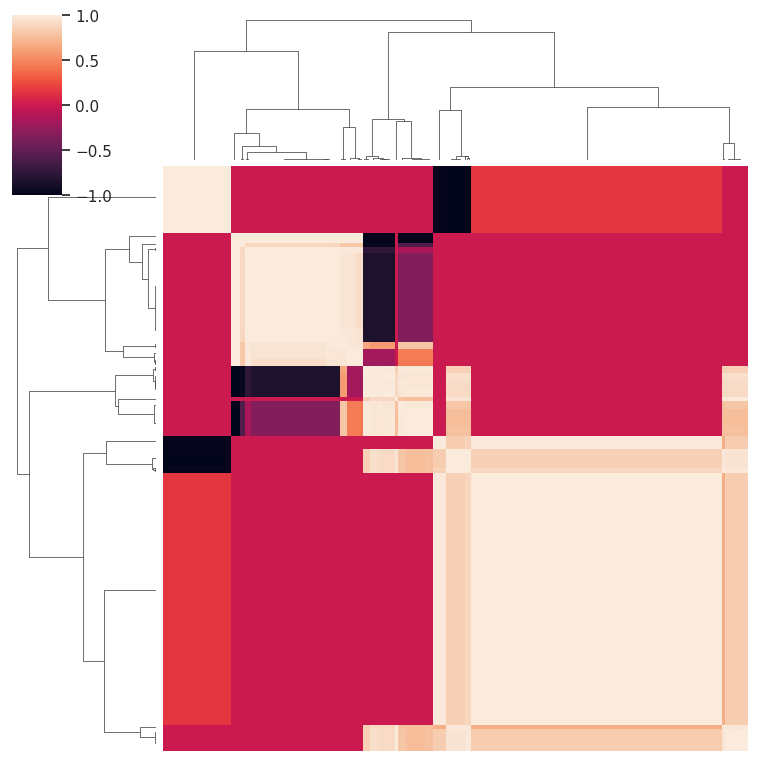

In [282]:
grid = sns.clustermap(high_var_genes_df_pivot.corr().fillna(0))
ax = grid.fig.axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [283]:
import scipy.cluster.hierarchy as spc

corr = high_var_genes_df_pivot.corr().fillna(0).values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.25 * pdist.max(), 'distance')
signature_clusters = dict(zip(high_var_genes_df_pivot.columns, idx))
clusters = np.unique(idx)

In [297]:
def get_prototype(cluster_idx):
    signatures = [signature for signature, idx in signature_clusters.items() if idx == cluster_idx]
    cluster_df = variance_df[variance_df['signature'].isin(signatures)]
    return max(cluster_df.signature, key=lambda x: cluster_df[cluster_df['signature'] == x]['var fixation'].values[0])

cluster_prototypes = {
    cluster: get_prototype(cluster)
    for cluster in clusters
}

In [306]:
for gene in high_var_genes_df['signature'].unique():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['fixation'])
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of genes with highest variance in fixation')
plt.show()

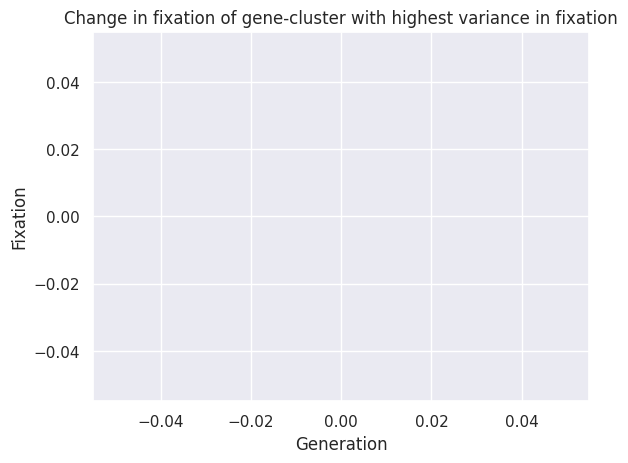

In [300]:
for gene in cluster_prototypes:
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['fixation'])
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of gene-cluster with highest variance in fixation')
plt.show()

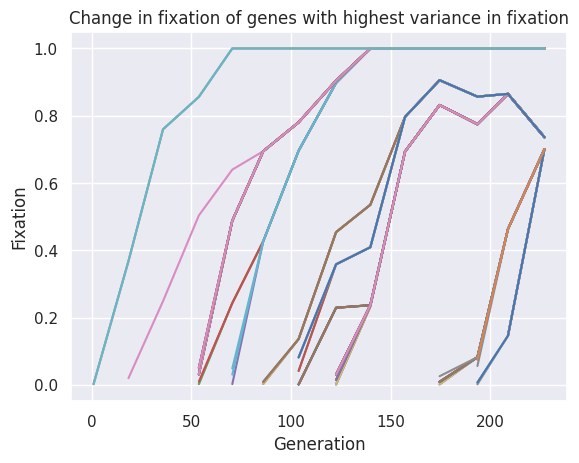

In [204]:
for gene in highest_variance_genes['signature'].unique():
    gene_ts = high_var_genes_df[high_var_genes_df['signature'] == gene]
    plt.plot(gene_ts['generation'], gene_ts['fixation'])
plt.xlabel('Generation')
plt.ylabel('Fixation')
plt.title('Change in fixation of genes with highest variance in fixation')
plt.show()

In [68]:
gene_signatures = {
    k : pd.DataFrame([
        {'signature': gene['signature']}
        for genome in genomes
        for gene in genome['sensorNeuronGenes'] + genome['outputNeuronGenes'] + genome['hiddenNeuronGenes'] + genome['synapseGenes']
    ])
    for k, genomes in genomes.items()
}

In [125]:
sig_counts = sig_df.value_counts()
sig_counts

signature           
-6178731546090058302    625
-7509010841315095574    625
 5000692776367050206    625
-1767037141039363740    625
-5912649970542296754    625
                       ... 
-107751674414350122       1
-100834482045301512       1
-58070365846548484        1
-29012165549407311        1
 9218674055462276439      1
Length: 1923, dtype: int64

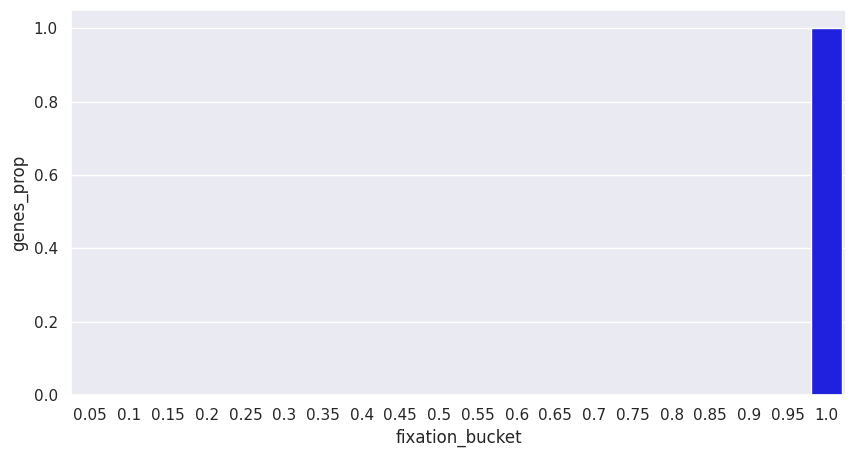

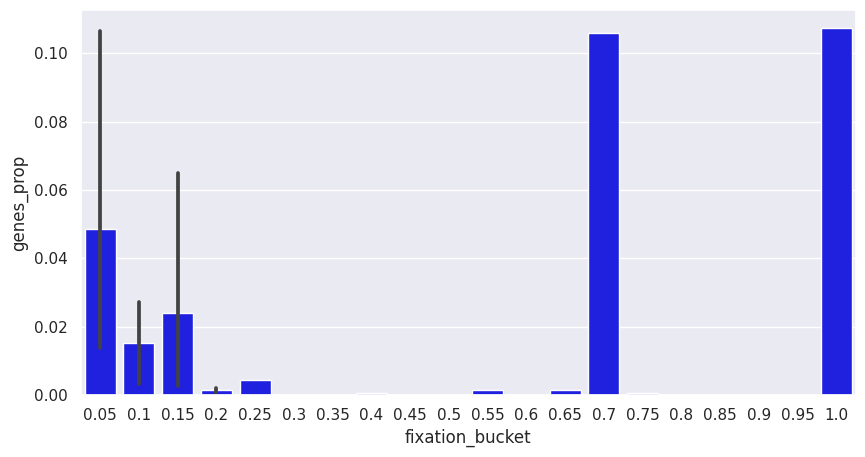

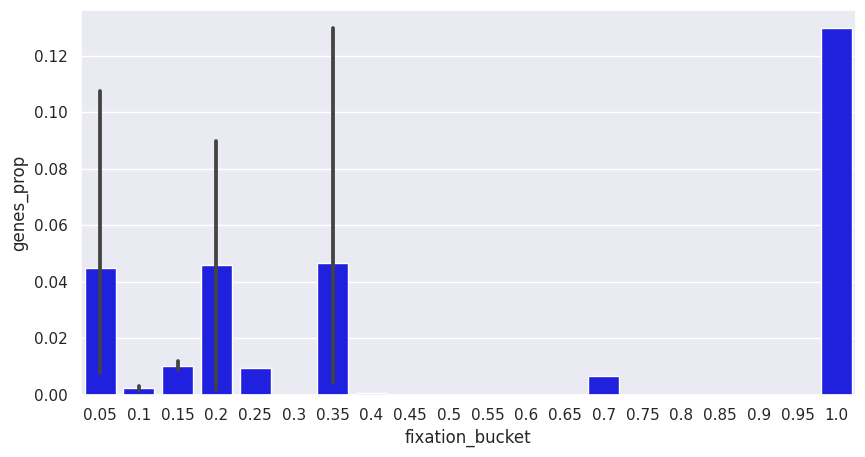

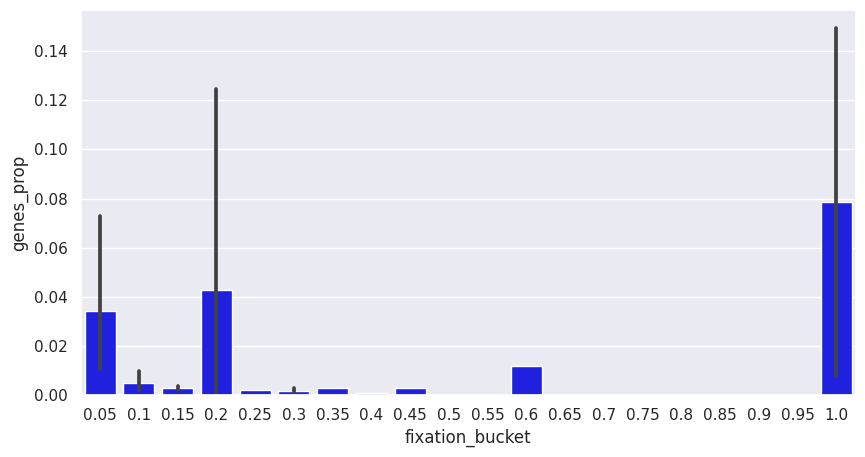

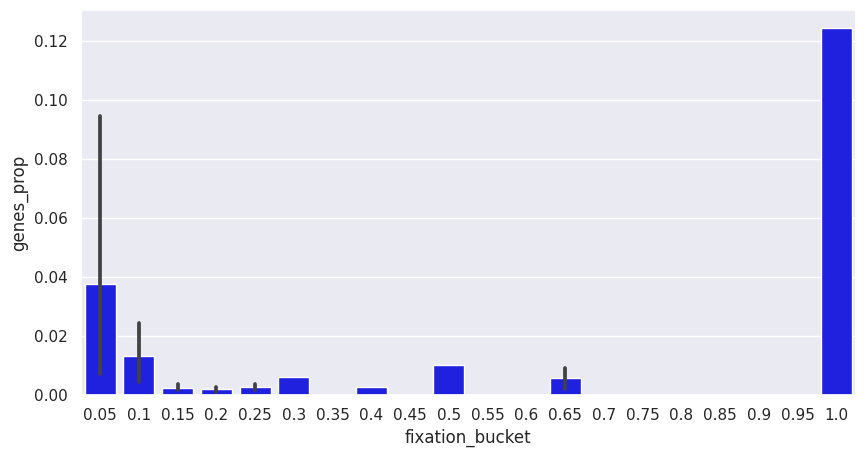

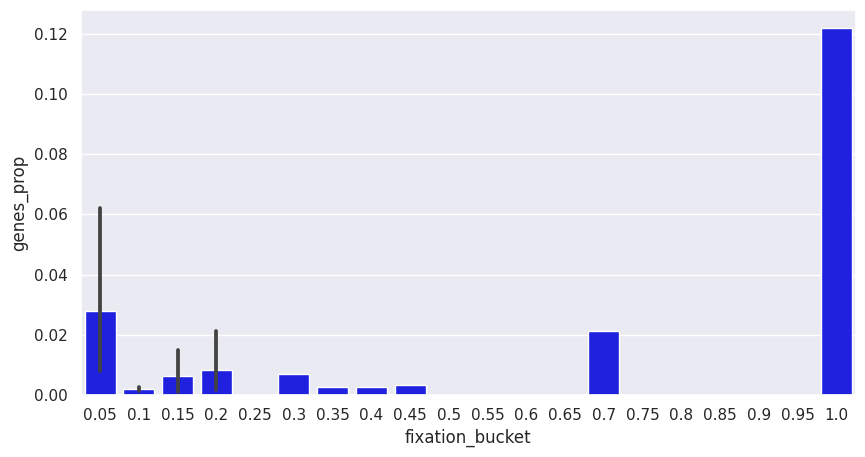

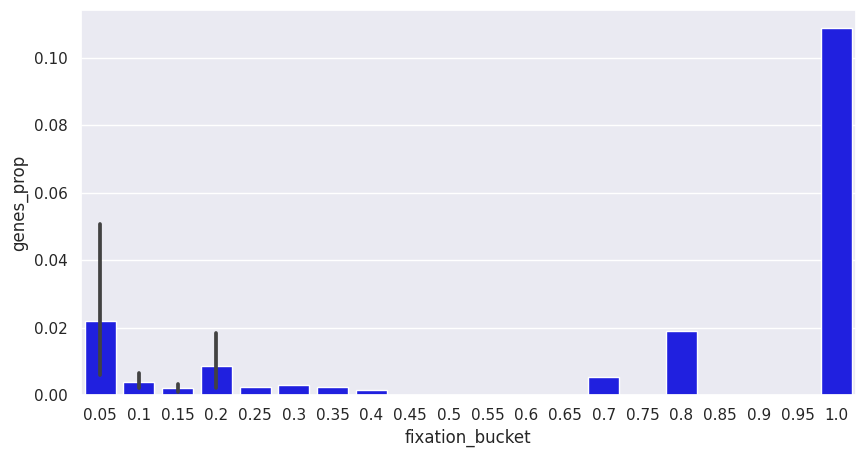

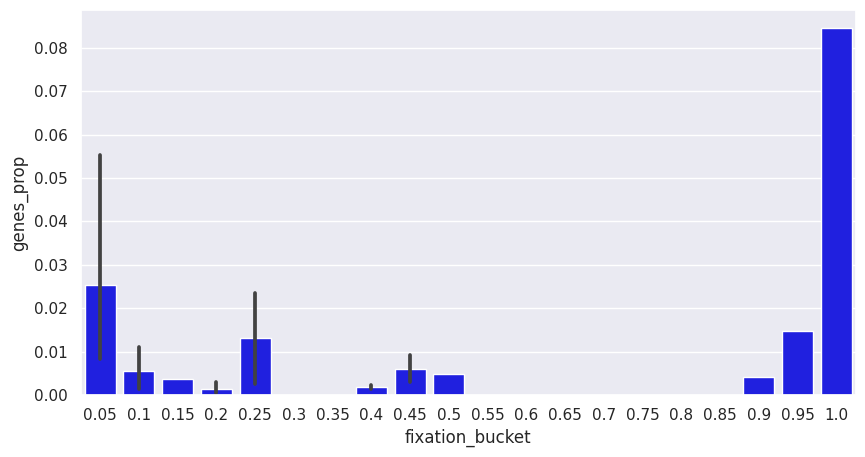

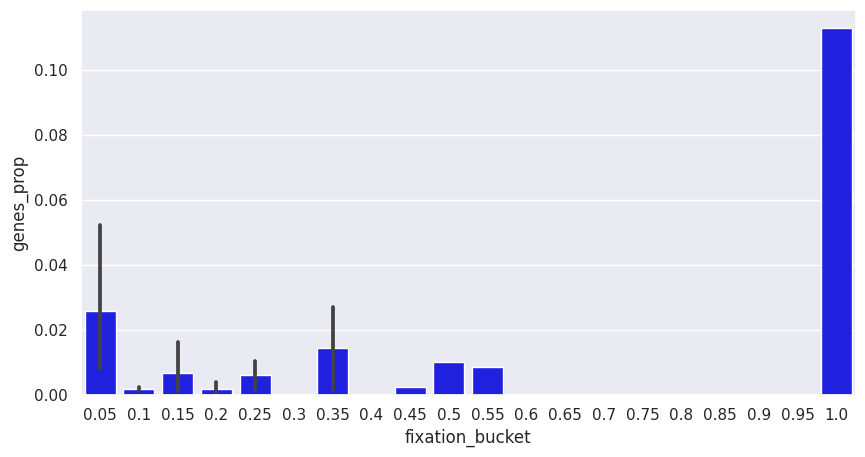

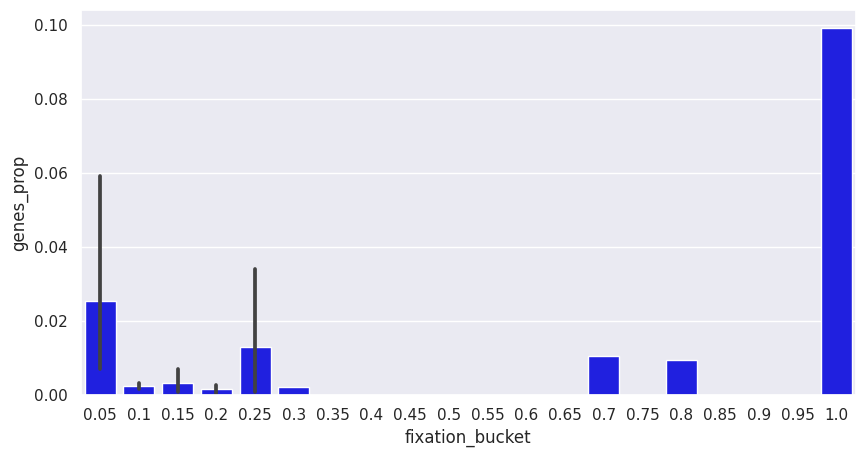

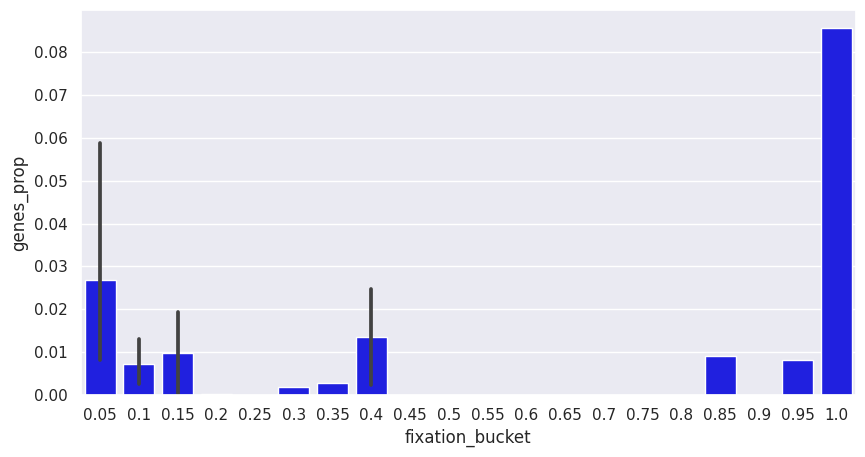

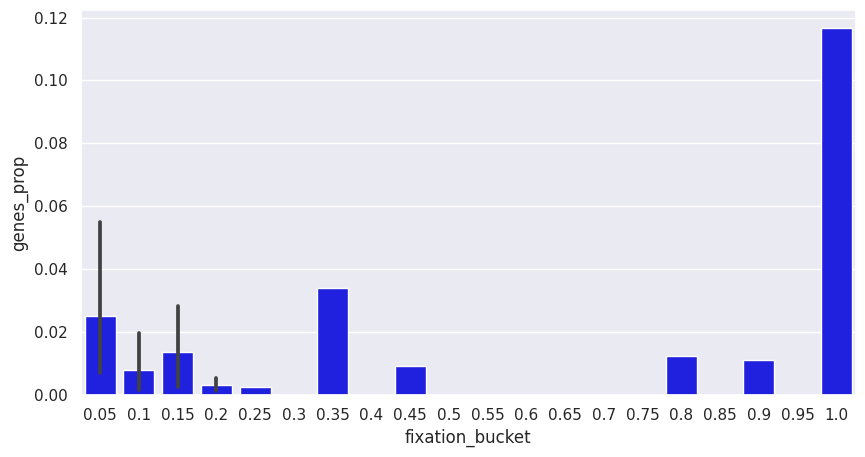

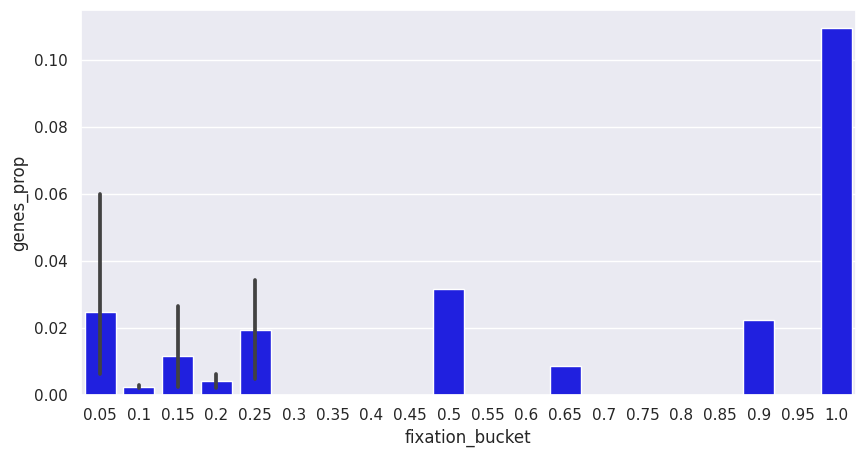

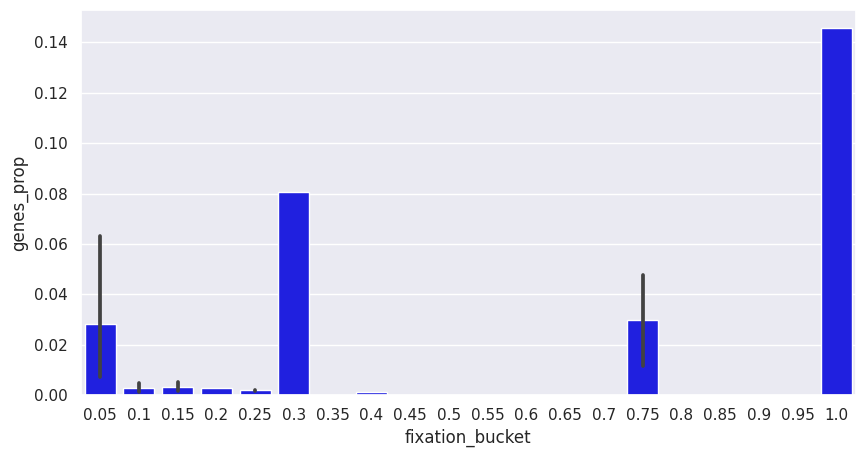

In [121]:
for sig_df in gene_signatures.values():
    sig_counts = sig_df.value_counts()

    counts_counts_df = pd.DataFrame(sig_counts.value_counts()).reset_index()
    counts_counts_df['fixation'] = counts_counts_df['index'] / counts_counts_df['index'].max()
    counts_counts_df['genes_prop'] = counts_counts_df[0] / counts_counts_df[0].sum()

    # bucket df by fixation
    n = 20
    bins = [(i / n, (i + 1) / n) for i in range(n)]
    labels = [f'{upper}' for _, upper in bins]
    bins = pd.IntervalIndex.from_tuples(bins)
    counts_counts_df['fixation_bucket'] = pd.cut(counts_counts_df['fixation'], bins=bins)

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=counts_counts_df, x='fixation_bucket', y='genes_prop', color='blue')
    ax.set_xticklabels(labels=labels)
    plt.show()

In [ ]:
json.load(open(list(stats_dir.glob('*.json'))[0]))

{'stats': {'Size Mean': {'name': 'Size Mean',
   'type': 'DOUBLE',
   'value': 0.060796857092529515,
   'error': 0.017366723876665192,
   'unit': {'units': {'DISTANCE': 1}}},
  'Meat Digestion Rate Mean': {'name': 'Meat Digestion Rate Mean',
   'type': 'DOUBLE',
   'value': 0.9013884544372559,
   'error': 0.38398706196751303,
   'unit': {'units': {'MASS': 1, 'TIME': -1}}},
  'Node 0: Angle Log Mean': {'name': 'Node 0: Angle Log Mean',
   'type': 'DOUBLE',
   'value': 4.907737297702818,
   'error': 0.9726952155756764,
   'unit': None},
  'Node 0: Node Exists Mean': {'name': 'Node 0: Node Exists Mean',
   'type': 'DOUBLE',
   'value': 0.0,
   'error': 0.0,
   'unit': None},
  'Repair Rate Log Mean': {'name': 'Repair Rate Log Mean',
   'type': 'DOUBLE',
   'value': -1.6889786793469244,
   'error': 0.9852669431075484,
   'unit': None},
  'Age Mean': {'name': 'Age Mean',
   'type': 'DOUBLE',
   'value': 0.0,
   'error': 0.0,
   'unit': {'units': {'TIME': 1}}},
  'Bodies': {'name': 'Bodies',